In [1]:
## Imports and Initialization -------------------------------------------------|
print("Importing dependencies... ")

import sys
import os, os.path
import re
sys.path.append(os.path.abspath(".."))  # Adjust path to package root

# third party
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# internal
import abstraction
import algorithm
from utility import IndexSchema, get_fits_paths
from examples.fits_to_mp4 import fits_to_mp4
from reference_method import OMargin

## Fetch Data ------------------------------------------------------------------

files_dir = os.path.abspath(os.path.join(".", "media", "large"))
files_regex = re.compile(
    "^whitelight\.cln\.\d{8}_\d{6}\.im\d{5}\.seq\d{3}\.ext\d{3}\.fits$"
    #"^test_1k_\d{2}\.fits$"
)
files = [
    os.path.join(files_dir, filename)
    for filename in os.listdir(files_dir)
    if files_regex.match(filename)
]
files.sort()
files = files[610:722]
# print("\n".join(files))
print(f"{len(files)} files found")


<>:25: SyntaxWarning: invalid escape sequence '\.'
<>:25: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_29673/1398532590.py:25: SyntaxWarning: invalid escape sequence '\.'
  "^whitelight\.cln\.\d{8}_\d{6}\.im\d{5}\.seq\d{3}\.ext\d{3}\.fits$"


Importing dependencies... 
112 files found



# Perform Destretching:

In [2]:
# create variable paths for destretching files

kernel_sizes: np.ndarray[np.int64] = np.array([64, 32])
out_off_dir = os.path.join(files_dir, "off")
out_avg_dir = os.path.join(files_dir, "avg")
out_dir = os.path.join(files_dir, "destretched")
print(out_off_dir)
print(out_avg_dir)
print(out_dir)

Destretching images... 
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched


In [ ]:
# calculate offset vectors
print(f"calculating offsets... {out_off_dir}")
abstraction.calc_offset_vectors(
    files,
    out_off_dir,
    "offset",
    kernel_sizes=kernel_sizes
)

calculating offsets... /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off
Searching for image data in specified files...
processing image #0../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06100.seq021.ext221.fits
processing image #1../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06110.seq021.ext231.fits
processing image #2../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06120.seq021.ext241.fits
processing image #3../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06130.seq021.ext251.fits
processing image #4../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06140.seq021.ext261.fits
processing image #5../home/

In [3]:
# calculate rolling mean
print(f"calculating offset rolling mean... {out_avg_dir}")
abstraction.calc_rolling_mean(
    get_fits_paths(out_off_dir),
    out_avg_dir,
    "average"
)


calculating offset rolling mean... /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg
Searching for image data in specified files...
averaging data #0..
averaging data #1..
averaging data #2..
averaging data #3..
averaging data #4..
averaging data #5..
averaging data #6..
averaging data #7..
averaging data #8..
averaging data #9..
averaging data #10..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/average000.avg.fits..
averaging data #11..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/average001.avg.fits..
averaging data #12..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/average002.avg.fits..
averaging data #13..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/average003.avg.fits..
averaging data #14..
writing /home/tteck/Documents/development/flct_destre

In [3]:
# do actual destretch
result = abstraction.destretch_files(
    files,
    get_fits_paths(out_off_dir),
    get_fits_paths(out_avg_dir),
    out_dir,
    kernel_sizes=kernel_sizes,
    ref_method=OMargin(files, 10, 10)
)


Searching for image data in specified files...
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched000.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched001.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched002.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched003.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched004.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched005.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destretched006.fits
destretched /home/tteck/Documents/development/flct_destre

In [3]:
# output video files
out_file_orig_vid = os.path.join(files_dir, "video_original.mp4")
out_file_destr_vid = os.path.join(files_dir, "video_destretched.mp4")
out_file_flow_vid = os.path.join(files_dir, "video_flowmap.mp4")
out_file_off_vid = os.path.join(files_dir, "video_offmap.mp4")

# output results as video files
fits_to_mp4(files, out_file_orig_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(out_dir, out_file_destr_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(out_avg_dir, out_file_flow_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25, True)
fits_to_mp4(out_off_dir, out_file_off_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25, True)

print("Demo Complete!")

Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_original.mp4, with 112 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_destretched.mp4, with 112 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_flowmap.mp4, with 112 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap.mp4, with 112 frames
Demo Complete!


(2, 1000, 1000)


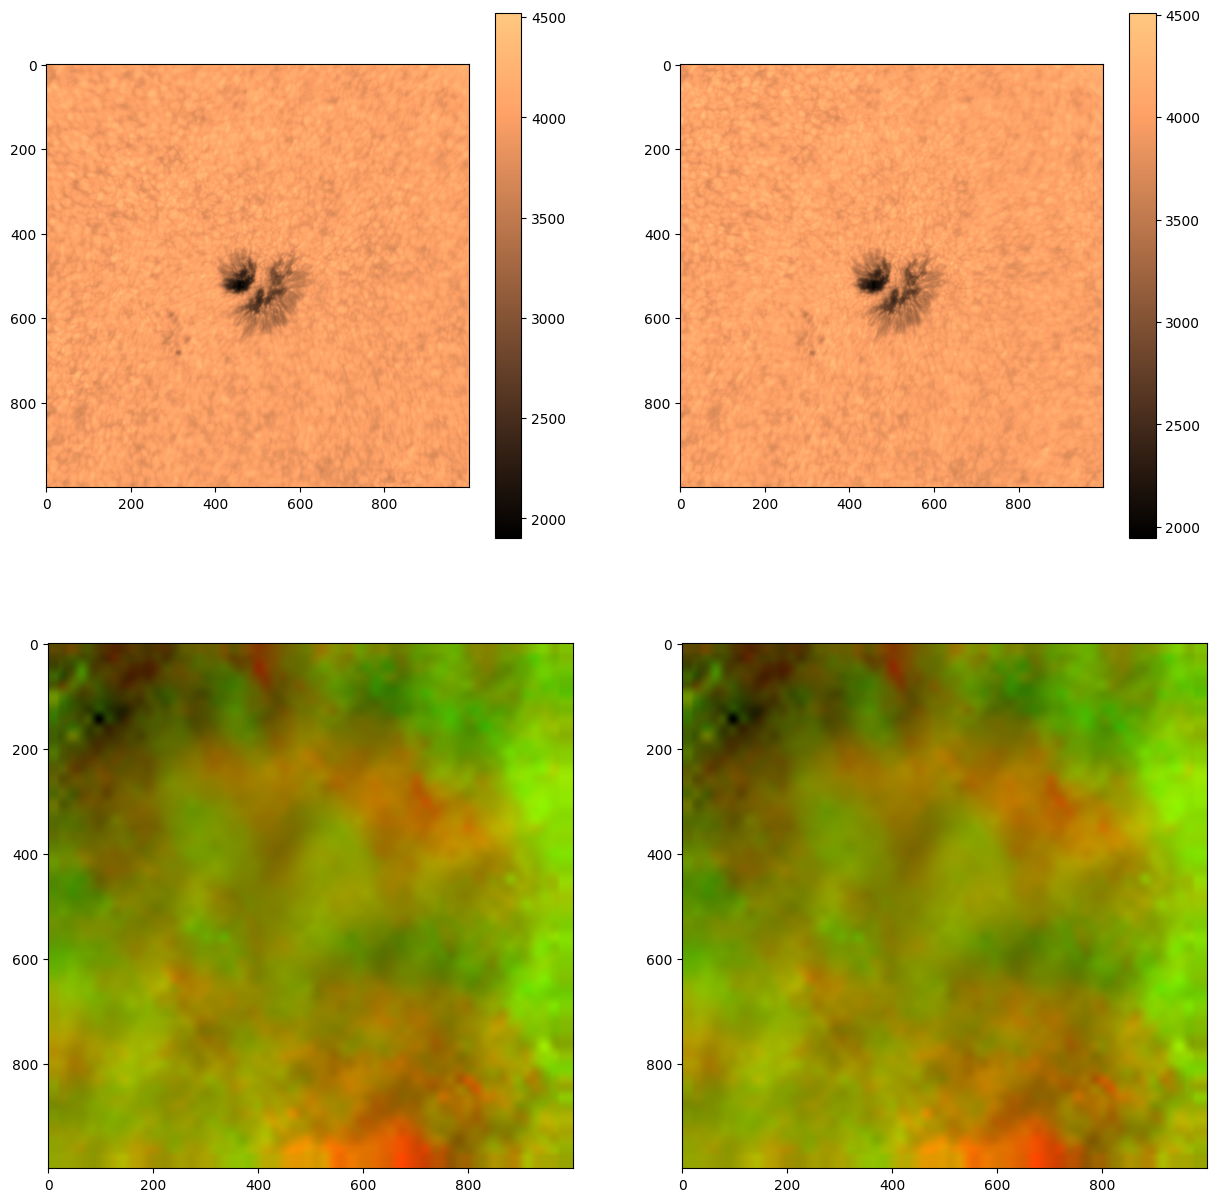

In [13]:
out_offs = get_fits_paths(out_off_dir)
out_off_stored = fits.open(out_offs[6])[0].data
out_off_stored_range = out_off_stored.max() - out_off_stored.min()

file5 = fits.open(files[5])[0].data
file6 = fits.open(files[6])[0].data
_, disp_sum, rdisp_sum, _ = algorithm.reg_loop(file6, file5, [64, 32])
out_off_calced = disp_sum - rdisp_sum
out_off_calced_range = out_off_calced.max() - out_off_calced.min()
print(out_off_calced.shape)

plt.figure(figsize=(15,15))
plt.colorbar(plt.subplot(2, 2, 1).imshow(fits.open(files[5])[0].data, cmap="copper"))
plt.colorbar(plt.subplot(2, 2, 2).imshow(fits.open(files[6])[0].data, cmap="copper"))
plt.subplot(2, 2, 3).imshow(
    np.transpose(np.array([
        (out_off_stored[0,:,:] - out_off_stored.min()) / out_off_stored_range,
        (out_off_stored[1,:,:] - out_off_stored.min()) / out_off_stored_range,
        np.zeros((1000,1000)),
    ]), (1,2,0))
)
plt.subplot(2, 2, 4).imshow(
    np.transpose(np.array([
        (out_off_calced[0,:,:] - out_off_calced.min()) / out_off_calced_range,
        (out_off_calced[1,:,:] - out_off_calced.min()) / out_off_calced_range,
        np.zeros((1000,1000)),
    ]), (1,2,0))
)

plt.show()